# **RoNIN Batch Analysis Pipeline**
### **Benchmark of Manifold-Aware Filters for 6DoF Pose Estimation**

**Authors:**  Ilya Afanasyev  
**Project:**  Filter-based (ESKF, UKF) vs Observer-based (GeoDQ) Fusion Strategies  

### **Overview**

This notebook implements a comprehensive evaluation pipeline for 6DoF pose estimation algorithms on the **RoNIN dataset**. It benchmarks three distinct architectures for Inertial Navigation Systems (INS) aided by global position updates via Visual Odometry (VO), comparing standard Python implementations against Numba-optimized (JIT) versions:

1.  **ESKF**: Standard Error-State Kalman Filter (Baseline).
2.  **UKF-M**: Manifold-aware Unscented Kalman Filter (Sigma-point based).
3.  **GeoDQ**: Geometric Dual Quaternion Observer (Non-linear Observer on $SE(3)$).

The pipeline includes trajectory processing, accuracy metrics (RMSE, ATE), execution time profiling, and robustness tests against sparse VO/GPS updates.

---

## Cell 1: Environment Setup and Imports

In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm 

# Performance and visualization settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# High-contrast scientific color palette for publication
COLORS = {
    'GT': '#000000',       # Ground Truth - Black
    'ESKF': '#9467bd',     # ESKF - Purple
    'ESKF-JIT': '#9467bd', # ESKF (JIT) - Purple
    'UKF': '#1f77b4',      # UKF-M - Blue
    'UKF-JIT': '#1f77b4',  # UKF-M (JIT) - Blue
    'GeoDQ': '#d62728',    # GeoDQ - Red
    'GeoDQ-JIT': '#d62728' # GeoDQ (JIT) - Red (Proposed Method)
}

print("✓ Environment initialized successfully.")

✓ Environment initialized successfully.


## Cell 2: Path Configuration

In [2]:
# Project directory structure
BASE_DIR = Path('D:/test') # Update this path to your local data directory
DATA_DIR = BASE_DIR / 'RoNIN_Standardized_Dataset' / 'csv_data'
RESULT_DIR = BASE_DIR / 'RoNIN_Standardized_Dataset' / 'results_Benchmark_GeoDQ'

# Create output directories
PLOTS_DIR = RESULT_DIR / 'plots'
STATS_DIR = RESULT_DIR / 'statistics'

for folder in [PLOTS_DIR, STATS_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

# List available trajectories
trajectories = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
print(f"✓ Found {len(trajectories)} trajectories in dataset.")
print(f"✓ Results will be saved to: {RESULT_DIR.absolute()}")

✓ Found 35 trajectories in dataset.
✓ Results will be saved to: D:\test\RoNIN_Standardized_Dataset\results_Benchmark_GeoDQ


## Cell 3: Load Filter Kernels

In [3]:
import importlib.util
import sys

def load_source_code(filename):
    """
    Imports a Python module from file and injects its contents into globals.
    This allows Numba caching to work correctly by preserving file attributes.
    """
    file_path = Path(filename)
    if not file_path.exists():
        raise FileNotFoundError(f"Kernel file not found: {filename}")

    # Create module name from filename
    module_name = file_path.stem

    # Load spec and module standard way
    spec = importlib.util.spec_from_file_location(module_name, str(file_path))
    if spec is None or spec.loader is None:
        raise ImportError(f"Could not load spec for {filename}")
        
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module # Register module
    spec.loader.exec_module(module)   # Execute module

    # Inject contents into global namespace to simulate standard script execution
    for name in dir(module):
        if not name.startswith('__'):
            globals()[name] = getattr(module, name)

    print(f"✓ Loaded & Imported: {filename}")

# Load algorithmic kernels
# Ensure these .py files are in the same directory as the notebook
try:
    load_source_code('ESKF_INS.py')
    load_source_code('ESKF_INS_JIT.py')
    load_source_code('UKFM_INS.py')
    load_source_code('UKFM_INS_JIT.py') 
    load_source_code('GeoDQ_SCLERP.py')   
    load_source_code('GeoDQ_SCLERP_JIT.py') 
    print("\n✓ All 6 architectures (Standard & JIT) are ready.")
except Exception as e:
    print(f"\nError loading kernels: {e}")
    import traceback
    traceback.print_exc()

✓ Loaded & Imported: ESKF_INS.py
✓ Loaded & Imported: ESKF_INS_JIT.py
✓ Loaded & Imported: UKFM_INS.py
✓ Loaded & Imported: UKFM_INS_JIT.py
✓ Loaded & Imported: GeoDQ_SCLERP.py
✓ Loaded & Imported: GeoDQ_SCLERP_JIT.py

✓ All 6 architectures (Standard & JIT) are ready.


## Cell 4: Visualization Engine

In [4]:
def plot_benchmark_results(traj_id, data, output_path):
    """
    Generates a 4-panel comparison figure.
    Note: Plots the JIT versions as the primary visualization since 
    trajectories are mathematically identical to standard versions.
    """
    gt = data['gt']
    fig = plt.figure(figsize=(18, 12), dpi=120, facecolor='white')
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 2])
    
    # Panel 1: 3D Trajectory
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    ax1.plot(gt[:, 0], gt[:, 1], gt[:, 2], color=COLORS['GT'], label='Ground Truth', lw=2.5)
    
    # Plotting JIT versions for visual clarity
    ax1.plot(data['p_eskf'][:, 0], data['p_eskf'][:, 1], data['p_eskf'][:, 2], 
             color=COLORS['ESKF'], label='ESKF', lw=1.5, alpha=0.7)
    ax1.plot(data['p_ukf'][:, 0], data['p_ukf'][:, 1], data['p_ukf'][:, 2], 
             color=COLORS['UKF'], label='UKF-M', lw=1.8)
    ax1.plot(data['p_dq'][:, 0], data['p_dq'][:, 1], data['p_dq'][:, 2], 
             color=COLORS['GeoDQ'], label='GeoDQ', lw=1.8, ls='--', alpha=0.9)
    
    ax1.set_title(f"3D Trajectory Comparison: {traj_id}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("X [m]"); ax1.set_ylabel("Y [m]"); ax1.set_zlabel("Z [m]")
    ax1.legend()

    # Panel 2: XY Projection (Top-Down View)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(gt[:, 0], gt[:, 1], color=COLORS['GT'], lw=2.5, label='GT')
    ax2.plot(data['p_eskf'][:, 0], data['p_eskf'][:, 1], color=COLORS['ESKF'], lw=1.5, alpha=0.7)
    ax2.plot(data['p_ukf'][:, 0], data['p_ukf'][:, 1], color=COLORS['UKF'], lw=1.8)
    ax2.plot(data['p_dq'][:, 0], data['p_dq'][:, 1], color=COLORS['GeoDQ'], lw=1.8, ls='--', alpha=0.9)
    ax2.set_aspect('equal')
    ax2.set_title("XY Top-Down Projection", fontsize=14, fontweight='bold')
    ax2.set_xlabel("X [m]"); ax2.set_ylabel("Y [m]")

    # Panel 3: Euclidean Error Evolution
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(data['err_eskf'], color=COLORS['ESKF'], alpha=0.5, label='ESKF')
    ax3.plot(data['err_ukf'], color=COLORS['UKF'], lw=1.5, label='UKF-M')
    ax3.plot(data['err_dq'], color=COLORS['GeoDQ'], alpha=0.8, ls='--', label='GeoDQ')
    ax3.set_title("Pose Error Over Time", fontsize=14, fontweight='bold')
    ax3.set_ylabel("Error [meters]"); ax3.set_xlabel("Sample Index")
    ax3.legend(ncol=3)

    # Panel 4: Error Statistical Distribution
    ax4 = fig.add_subplot(gs[1, 1])
    # Boxplots represent the distribution of errors for the entire trajectory
    error_data = [data['err_eskf'], data['err_ukf'], data['err_dq']]
    bp = ax4.boxplot(error_data, patch_artist=True, labels=['ESKF', 'UKF-M', 'GeoDQ'])
    
    colors_list = [COLORS['ESKF'], COLORS['UKF'], COLORS['GeoDQ']]
    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax4.set_title("Error Statistics Distribution", fontsize=14, fontweight='bold')
    ax4.set_ylabel("Error [m]")

    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()
    return str(output_path)

## Cell 5: RoNIN Benchmark Core

In [5]:
class RoNINBenchmark:
    """
    Core engine for benchmarking 6DoF filters on the RoNIN dataset.
    Handles data loading, filtering loop execution, metric calculation, and robustness testing.
    """    
    def __init__(self, data_dir, plots_dir, stats_dir):
        self.data_dir = Path(data_dir)
        self.plots_dir = Path(plots_dir)
        self.stats_dir = Path(stats_dir)
        self.dt = 0.005 # Default dt for 200Hz, will be updated based on actual data

    def _load_trajectory_data(self, traj_id):
        """
        Helper to load IMU and Ground Truth (Pose) data.
        Tries to load Visual Odometry (vo.csv) first, falling back to gps.csv.
        """
        p = self.data_dir / traj_id
        imu_path = p / 'imu.csv'
        
        # Try 'vo.csv' first (Visual Odometry), then fallback to 'gps.csv'
        vo_path = p / 'vo.csv'
        if not vo_path.exists():
            vo_path = p / 'gps.csv'
            
        if not imu_path.exists() or not vo_path.exists():
            raise FileNotFoundError(f"Missing data files in {p}. Ensure imu.csv and vo.csv exist.")
            
        imu_df = pd.read_csv(imu_path)
        vo_df = pd.read_csv(vo_path) 
        return imu_df, vo_df

    def _get_metrics(self, est, gt):
        """Calculates RMSE and ATE (Absolute Trajectory Error)."""
        errors = np.linalg.norm(np.array(est) - gt, axis=1)
        return {
            'rmse': np.sqrt(np.mean(errors**2)),
            'ate': np.mean(errors),
            'raw_errors': errors
        }

    def process_sequence(self, traj_id, show_plot=True):
        """
        Runs all 6 filters (Standard & JIT) on a single trajectory.
        Returns metrics and timing data.
        """
        imu_data, vo_data = self._load_trajectory_data(traj_id)
        
        t_imu = imu_data['time'].values
        acc = imu_data[['ax','ay','az']].values
        gyro = imu_data[['wx','wy','wz']].values
        
        t_gt = vo_data['time'].values
        gt_pos = vo_data[['X','Y','Z']].values
        
        # Calculate sampling time
        dt = np.mean(np.diff(t_imu))
        self.dt = dt
        N = len(t_imu)
        
        # Data Preparation: Ensure float64 for Numba compatibility
        p0 = gt_pos[0].astype(np.float64)
        q0 = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64)
        
        # Interpolate Ground Truth to IMU timestamps for evaluation/updates
        gt_interp = np.array([np.interp(t_imu, t_gt, gt_pos[:, k]) for k in range(3)]).T

        # 1. Initialize Filters (Standard & JIT)
        
        # --- ESKF ---
        eskf = ESKF_INS(dt, R_pos=np.eye(3)*0.25); eskf.set_state(p0, np.zeros(3), q0)
        eskf_jit = ESKF_INS_JIT(dt, R_pos=np.eye(3)*0.25); eskf_jit.set_state(p0, np.zeros(3), q0)

        # --- UKF-M ---
        ukf = UKF_M(dt, R_pos=0.5); ukf.set_init(p0, q0)
        ukf_jit = UKF_M_JIT(dt, R_pos=0.5); ukf_jit.set_init(p0, q0)
        
        # --- GeoDQ ---
        dq = DQFilter(dt, kp_vel=0.8, ki_ba=0.01); dq.initialize(q0, p0)
        dq_jit = DQFilterJIT(dt, kp_vel=0.8, ki_ba=0.01); dq_jit.initialize(q0, p0)
        
        # Warmup JIT compiler with dummy data
        dq_jit.step(np.zeros(3), np.zeros(3), np.zeros(3))
        dq_jit.initialize(q0, p0)

        # Results Storage
        methods = ['eskf', 'eskf_jit', 'ukf', 'ukf_jit', 'dq', 'dq_jit']
        results = {m: np.zeros((N, 3)) for m in methods}
        timers = {m: 0.0 for m in methods}

        # 2. Main Processing Loop
        for i in range(N):
            # 2.1 ESKF Standard
            t_s = time.perf_counter()
            eskf.predict(gyro[i], acc[i]); eskf.update_vo(gt_interp[i])
            results['eskf'][i] = eskf.p
            timers['eskf'] += (time.perf_counter() - t_s)

            # 2.2 ESKF JIT
            t_s = time.perf_counter()
            eskf_jit.predict(gyro[i], acc[i]); eskf_jit.update_vo(gt_interp[i])
            results['eskf_jit'][i] = eskf_jit.p
            timers['eskf_jit'] += (time.perf_counter() - t_s)

            # 2.3 UKF Standard
            t_s = time.perf_counter()
            ukf.predict(gyro[i], acc[i]); ukf.update(gt_interp[i])
            results['ukf'][i] = ukf.position
            timers['ukf'] += (time.perf_counter() - t_s)

            # 2.4 UKF JIT
            t_s = time.perf_counter()
            ukf_jit.predict(gyro[i], acc[i]); ukf_jit.update(gt_interp[i])
            results['ukf_jit'][i] = ukf_jit.position
            timers['ukf_jit'] += (time.perf_counter() - t_s)
            
            # 2.5 GeoDQ Standard
            t_s = time.perf_counter()
            dq.step(gyro[i], acc[i], pos_meas=gt_interp[i])
            results['dq'][i] = dq.position
            timers['dq'] += (time.perf_counter() - t_s)

            # 2.6 GeoDQ JIT
            t_s = time.perf_counter()
            dq_jit.step(gyro[i], acc[i], pos_meas=gt_interp[i])
            results['dq_jit'][i] = dq_jit.position
            timers['dq_jit'] += (time.perf_counter() - t_s)

        # 3. Compute Metrics
        metrics = {}
        for m in methods:
            metrics[m] = self._get_metrics(results[m], gt_interp)

        # 4. Generate Plot (using JIT results for cleaner visualization)
        fig_path = None
        if show_plot:
            fig_path = self.plots_dir / f"{traj_id}_result.png"
            plot_benchmark_results(traj_id, {
                'gt': gt_interp, 
                'p_eskf': results['eskf_jit'], 
                'p_ukf': results['ukf_jit'], 
                'p_dq': results['dq_jit'],
                'err_eskf': metrics['eskf_jit']['raw_errors'], 
                'err_ukf': metrics['ukf_jit']['raw_errors'], 
                'err_dq': metrics['dq_jit']['raw_errors']
            }, fig_path)

        # 5. Compile Output Dictionary
        ret = {'trajectory': traj_id, 'plot': str(fig_path) if fig_path else None}
        for m in methods:
            ret[f'rmse_{m}'] = metrics[m]['rmse']
            ret[f'ate_{m}'] = metrics[m]['ate']
            ret[f'time_{m}'] = timers[m] * 1000 # Convert to ms
            
        return ret # <--- ВАЖНО: Эта строка должна быть здесь!

    def run_robustness_test(self, traj_list, max_decimation=10, is_batch=False):
        """
        Stress Test: Evaluates performance degradation with sparse Position (VO) updates.
        NOTE: Uses JIT-compiled classes for execution speed. 
        """
        intervals = np.arange(1, max_decimation + 1)
        stats = {m: {i: [] for i in intervals} for m in ['ESKF', 'UKF', 'GeoDQ']}
        
        for traj_id in tqdm(traj_list, desc="Robustness Analysis"):
            imu_data, vo_data = self._load_trajectory_data(traj_id)
            
            t_imu = imu_data['time'].values
            acc = imu_data[['ax','ay','az']].values
            gyro = imu_data[['wx','wy','wz']].values
            
            t_gt = vo_data['time'].values
            gt_pos = vo_data[['X','Y','Z']].values
            
            dt = np.mean(np.diff(t_imu)); self.dt = dt
            N = len(t_imu)
            
            p0 = gt_pos[0].astype(np.float64)
            q0 = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64)
            gt_interp = np.array([np.interp(t_imu, t_gt, gt_pos[:, k]) for k in range(3)]).T

            for step in intervals:
                # Use JIT classes for speed
                f_eskf = ESKF_INS_JIT(dt, R_pos=np.eye(3)*0.25); f_eskf.set_state(p0, np.zeros(3), q0)
                f_ukf = UKF_M_JIT(dt, R_pos=0.5); f_ukf.set_init(p0, q0)
                f_dq = DQFilterJIT(dt, kp_vel=0.8, ki_ba=0.01); f_dq.initialize(q0, p0)
                # JIT Warmup
                f_dq.step(np.zeros(3), np.zeros(3), np.zeros(3)); f_dq.initialize(q0, p0)
                
                sse = {m: 0.0 for m in ['ESKF', 'UKF', 'GeoDQ']}
                
                for i in range(N):
                    # Prediction Step
                    f_eskf.predict(gyro[i], acc[i])
                    f_ukf.predict(gyro[i], acc[i])
                    
                    # Measurement Update (Simulating sparse VO updates)
                    pos_meas = gt_interp[i] if (i % step == 0) else None
                    
                    if pos_meas is not None:
                        f_eskf.update_vo(pos_meas)
                        f_ukf.update(pos_meas)
                    
                    # GeoDQ Step
                    f_dq.step(gyro[i], acc[i], pos_meas=pos_meas)
                    
                    # Accumulate Error
                    sse['ESKF'] += np.sum((f_eskf.p - gt_interp[i])**2)
                    sse['UKF']  += np.sum((f_ukf.position - gt_interp[i])**2)
                    sse['GeoDQ']+= np.sum((f_dq.position - gt_interp[i])**2)

                for m in stats.keys():
                    stats[m][step].append(np.sqrt(sse[m] / N))

        self._plot_robustness(stats, intervals, is_batch, traj_list[0] if not is_batch else "Global")
        return stats

    def _plot_robustness(self, stats, intervals, is_batch, title_suffix):
        """Visualization for robustness analysis."""
        plt.figure(figsize=(13, 8), dpi=120)
        
        styles = {
            'ESKF': {'ls': '-', 'lw': 2.5, 'marker': 'o', 'ms': 6},
            'UKF':  {'ls': '-', 'lw': 2.5, 'marker': '^', 'ms': 6},
            'GeoDQ':{'ls': '--', 'lw': 3.0, 'marker': 's', 'ms': 6, 'alpha': 0.8}
        }
        
        for m in stats.keys():
            means = [np.mean(stats[m][i]) for i in intervals]
            plt.plot(intervals, means, color=COLORS.get(m, '#333333'), label=m, **styles.get(m, {}))
            if is_batch:
                stds = [np.std(stats[m][i]) for i in intervals]
                plt.fill_between(intervals, np.array(means)-stds, np.array(means)+stds, 
                                 color=COLORS.get(m, '#333333'), alpha=0.1)

        plt.yscale('log')
        plt.grid(True, which="both", alpha=0.3)
        plt.xlabel("Position Update Interval (Samples @ 200Hz)", fontsize=12)
        plt.ylabel("RMSE [m] (Log Scale)", fontsize=12)
        plt.title(f"Robustness Analysis: {title_suffix}", fontsize=14, fontweight='bold')
        plt.legend(loc='upper left', frameon=True, shadow=True)
        
        fname = "global_robustness.png" if is_batch else f"{title_suffix}_robustness.png"
        plt.savefig(self.stats_dir / fname, bbox_inches='tight')
        plt.show()

## Cell 6: Run Fast Validation

In [7]:
# Initialize Pipeline
analyzer = RoNINBenchmark(DATA_DIR, PLOTS_DIR, STATS_DIR)

# Fast Validation (Single Trajectory)
if trajectories:
    res = analyzer.process_sequence(trajectories[0])
    print(f"Validation for {trajectories[0]}:")
    
    # Formatted Output
    print(f"{'Method':<12} | {'RMSE [m]':<10} | {'Time [ms]':<10}")
    print("-" * 38)
    print(f"{'ESKF':<12} | {res['rmse_eskf']:.4f}     | {res['time_eskf']:.1f}")
    print(f"{'ESKF-JIT':<12} | {res['rmse_eskf_jit']:.4f}     | {res['time_eskf_jit']:.1f}")
    print(f"{'UKF-M':<12} | {res['rmse_ukf']:.4f}     | {res['time_ukf']:.1f}")
    print(f"{'UKF-M-JIT':<12} | {res['rmse_ukf_jit']:.4f}     | {res['time_ukf_jit']:.1f}")
    print(f"{'GeoDQ':<12} | {res['rmse_dq']:.4f}     | {res['time_dq']:.1f}")
    print(f"{'GeoDQ-JIT':<12} | {res['rmse_dq_jit']:.4f}     | {res['time_dq_jit']:.1f}")

Validation for a000_11:
Method       | RMSE [m]   | Time [ms] 
--------------------------------------
ESKF         | 0.1548     | 4830.5
ESKF-JIT     | 0.1548     | 1408.0
UKF-M        | 0.2669     | 19647.5
UKF-M-JIT    | 0.2642     | 6427.2
GeoDQ        | 0.0456     | 9975.0
GeoDQ-JIT    | 0.0456     | 1293.9


## Cell 7: Single Trajectory Robustness

Robustness Analysis: 100%|██████████| 1/1 [05:33<00:00, 333.87s/it]


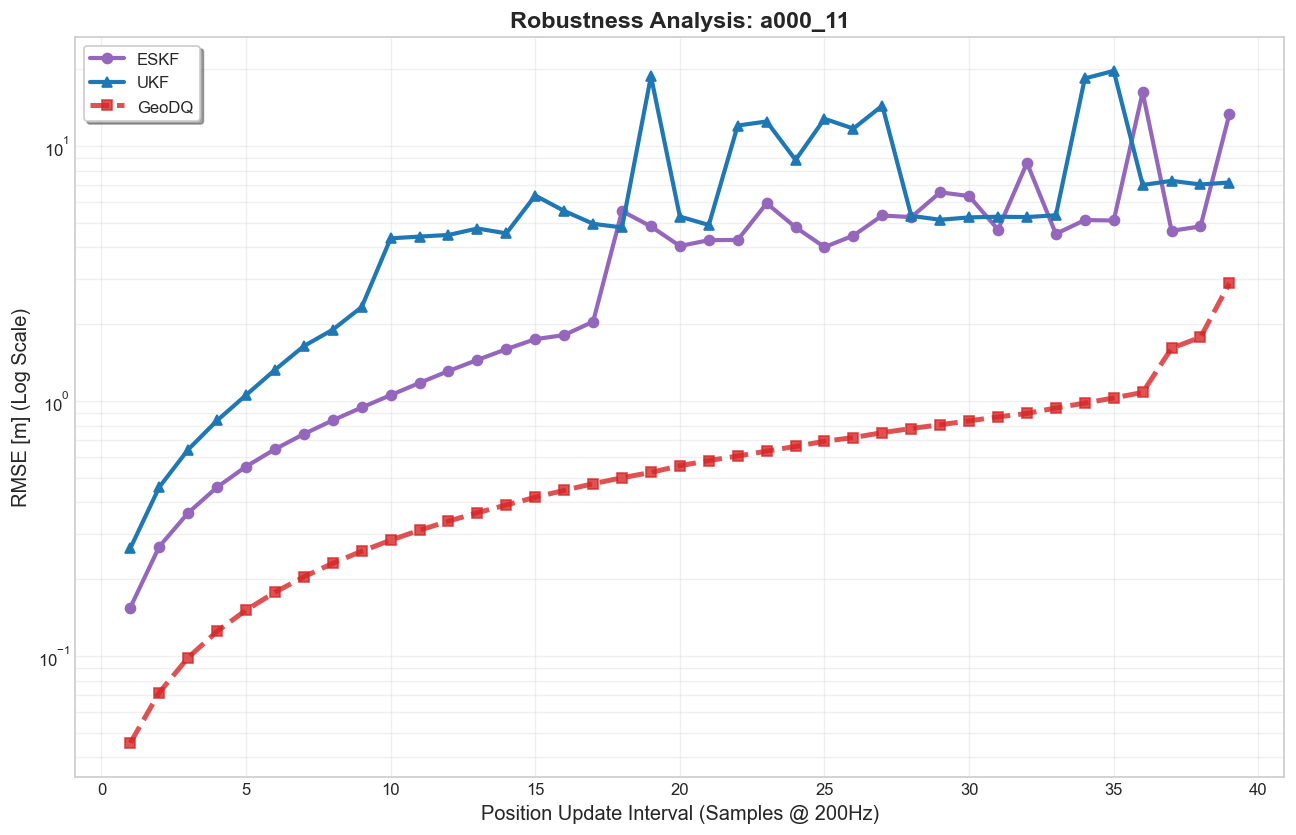

In [8]:
# Sensitivity Analysis (Single Trajectory)
# Tests how performance degrades as VO updates become sparser (every 1...39 samples).
# Uses JIT-compiled kernels for faster execution.
robustness_single = analyzer.run_robustness_test(trajectories[:1], max_decimation=39, is_batch=False)

## Cell 8: Batch Processing Execution

In [9]:
# Batch Processing (Full Dataset)
print(f"🚀 Starting Benchmark Pipeline...")
all_results = [analyzer.process_sequence(t, show_plot=True) for t in tqdm(trajectories, desc="Benchmark")]
df_results = pd.DataFrame(all_results)
df_results.to_csv(STATS_DIR / 'detailed_benchmark_results.csv', index=False)

🚀 Starting Benchmark Pipeline...


Benchmark: 100%|██████████| 35/35 [49:18<00:00, 84.53s/it]


## Cell 9: Statistical Analysis and Reporting

In [10]:
# Statistical Summary
valid = df_results.drop(columns=['plot'], errors='ignore').dropna()

if valid.empty:
    print("Warning: No valid data found after filtering! Check filter execution.")
else:
    def get_stats_row(name, prefix):
        # Safety check: ensure columns exist
        if f'rmse_{prefix}' not in valid.columns:
            return [name, "N/A", "N/A"]
            
        rmse_val = valid[f'rmse_{prefix}']
        time_val = valid[f'time_{prefix}']
        
        rmse = f"{rmse_val.mean():.4f} ± {rmse_val.std():.4f}"
        time = f"{time_val.mean():.1f}"
        return [name, rmse, time]

    summary_df = pd.DataFrame([
        get_stats_row("ESKF (Standard)", "eskf"),
        get_stats_row("ESKF (JIT)", "eskf_jit"),
        get_stats_row("UKF-M (Standard)", "ukf"),
        get_stats_row("UKF-M (JIT)", "ukf_jit"),
        get_stats_row("GeoDQ (Standard)", "dq"),
        get_stats_row("GeoDQ (JIT)", "dq_jit")
    ], columns=['Method', 'RMSE [m]', 'Execution [ms]'])

    print("\n" + "="*60 + "\nFINAL BENCHMARK SUMMARY\n" + "="*60)
    print(summary_df.to_markdown(index=False))


FINAL BENCHMARK SUMMARY
| Method           | RMSE [m]        |   Execution [ms] |
|:-----------------|:----------------|-----------------:|
| ESKF (Standard)  | 0.1409 ± 0.0213 |           9166.1 |
| ESKF (JIT)       | 0.1409 ± 0.0213 |           2807.8 |
| UKF-M (Standard) | 0.2329 ± 0.0382 |          38362.3 |
| UKF-M (JIT)      | 0.2312 ± 0.0378 |          12773.8 |
| GeoDQ (Standard) | 0.0377 ± 0.0081 |          18654.2 |
| GeoDQ (JIT)      | 0.0377 ± 0.0081 |           2430.3 |


## Cell 10: Global Robustness Test

Robustness Analysis: 100%|██████████| 35/35 [5:30:59<00:00, 567.40s/it]  


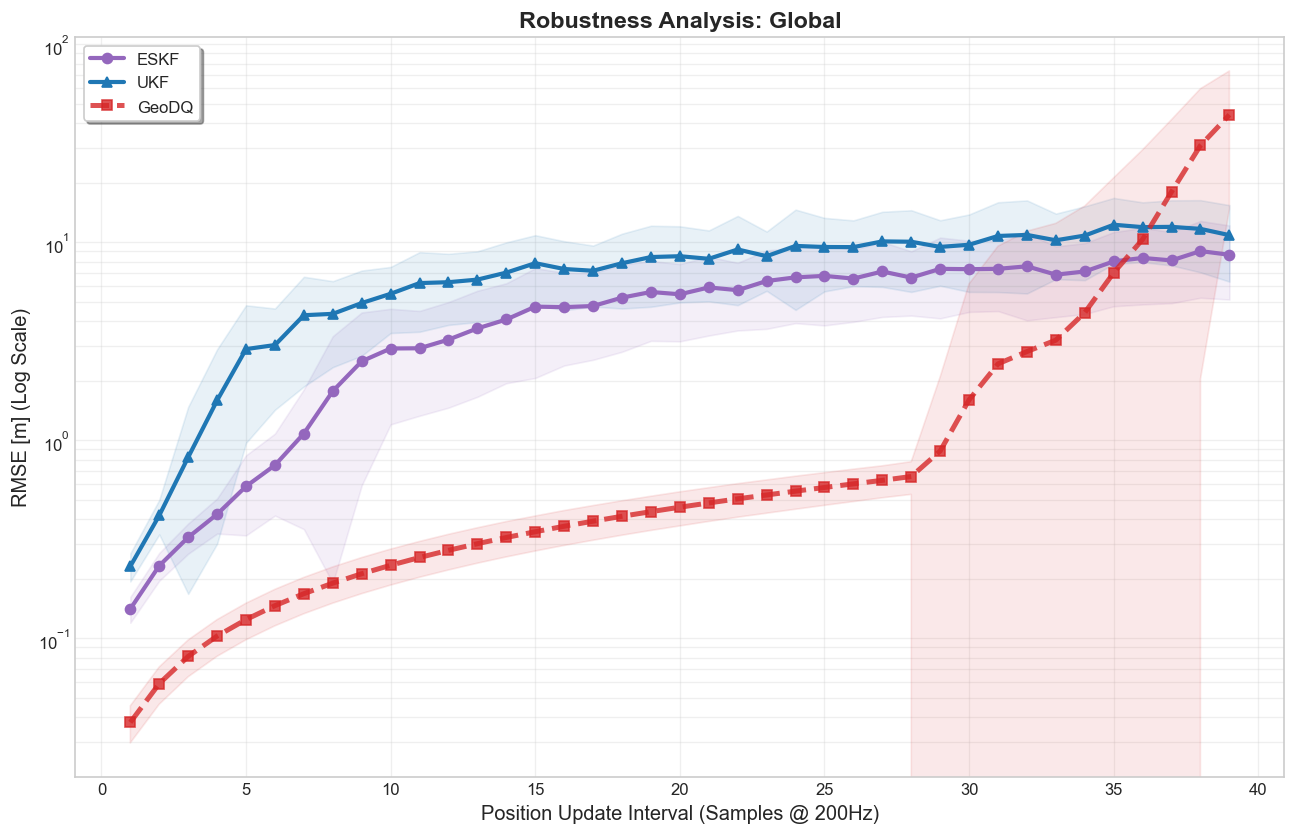

In [11]:
# Global Robustness Test (Full Dataset)
# Computes average degradation across all trajectories.
# Runs significantly faster thanks to JIT optimization in the loop.
global_robustness = analyzer.run_robustness_test(trajectories, max_decimation=39, is_batch=True)